In [1]:
import os
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import itertools
from google.colab import drive
import time
import cv2
import glob

import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.autograd import Variable
! pip install tensorboardX
from tensorboardX import SummaryWriter

     |████████████████████████████████| 204kB 8.8MB/s 


In [2]:
drive.mount('/content/drive/')

cwd = os.getcwd()
print(cwd)

#google driveのMy Drive内にあるinput.csvを選択
data_path = '/content/drive/My Drive/sentan2'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content


In [3]:
len(glob.glob(data_path+"/data/manga2anime/traindata_A/*"))

239

In [3]:
# ハイパラ
LOAD_SIZE = 143
FINE_SIZE = 128
BATCH_SIZE = 8
NUM_EPOCH = 501

lr =0.001
beta1 = 0.5

SAVE_FREQ = 10
LOG_DIR = "/content/drive/My Drive/sentan2/logs"

cuda = torch.cuda.is_available()
if cuda:
    print("cuda use")

cuda use


In [0]:
class DataLoader(torch.utils.data.Dataset):
    def __init__(self, is_train):
        super(DataLoader, self).__init__()

        root_dir = os.path.join(data_path+"/data", "manga2anime")
        print("root is {}".format(root_dir))
        # trainのディレクトリ
        if is_train:
            dir_A = os.path.join(root_dir, "traindata_A")
            dir_B = os.path.join(root_dir, "traindata_B")
        # testのディレクトリ
        else:
            dir_A = os.path.join(root_dir, "testdata_A")
            dir_B = os.path.join(root_dir, "testdata_B")

        self.path_A = self.make_dataset(dir_A)
        self.path_B = self.make_dataset(dir_B)

        self.size_A = len(self.path_A)
        self.size_B = len(self.path_B)
        print("A size : {}".format(self.size_A))
        print("B size : {}".format(self.size_B))
        self.transform_A2B = self.make_transform(is_train, side="A")
        self.transform_B2A = self.make_transform(is_train, side="B")

    def __getitem__(self, index):
        index_A = index % self.size_A
        imagepath_A = self.path_A[index_A]
        image_A = Image.open(imagepath_A).convert("L").convert("RGB")

        index_B = random.randint(0, self.size_B-1)
        imagepath_B = self.path_B[index_B]
        image_B = Image.open(imagepath_B).convert("RGB")

        A = self.transform_A2B(image_A)
        
        B = self.transform_B2A(image_B)

        return {"A":A, "B":B, "path_A":imagepath_A, "path_B":imagepath_B}

    def __len__(self):
        return max(self.size_A, self.size_B)

    def make_dataset(self, dirname):
        images =  []
        dirs = os.listdir(dirname)
        if len(dirs)==0:
            print("err")
        else:
            for fname in dirs:
                if fname.endswith(".jpg"):
                    path = os.path.join(dirname, fname)
                    images.append(path)
        
        return sorted(images)


    def make_transform(self, is_train, side):
        transforms_list = []
        transforms_list.append(transforms.Resize((LOAD_SIZE, LOAD_SIZE), Image.BICUBIC))
        transforms_list.append(transforms.RandomCrop(FINE_SIZE))
        if is_train:
            transforms_list.append(transforms.RandomVerticalFlip())
            transforms_list.append(transforms.RandomHorizontalFlip())
        transforms_list.append(transforms.ToTensor())
        transforms_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
        #if side=="B":
            #transforms_list.append(transforms.ToTensor())
            #transforms_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
        #elif side=="A":
            #transforms_list.append(transforms.Grayscale(num_output_channels=1))
            #transforms_list.append(transforms.ToTensor())
            #transforms_list.append(transforms.Normalize(mean=[0.5], std=[0.5]))
        return transforms.Compose(transforms_list)

In [5]:
train_dataset = DataLoader(is_train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=0)
print("train size : {}".format(len(train_loader)))

root is /content/drive/My Drive/sentan2/data/manga2anime
A size : 239
B size : 258
train size : 33


In [6]:
batch = iter(train_loader).next()
print(batch["A"].shape)

torch.Size([8, 3, 128, 128])


In [0]:
def imshow(img, save=False, fname=None):
    np_img = img.numpy()
    np_img = 1/2*(np_img+1)
    np_img = np.transpose(np_img, (1,2,0))
    plt.imshow(np_img)
    if save:
        assert fname is not None, "fname指定"
        plt.savefig(fname)

In [0]:
batch = iter(train_loader).next()
image_A = batch["A"]
image_B = batch["B"]

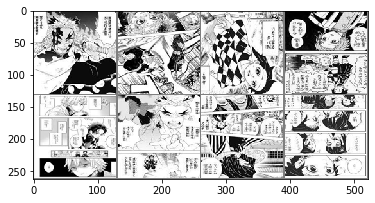

In [9]:
imshow(make_grid(image_A, nrow=4))

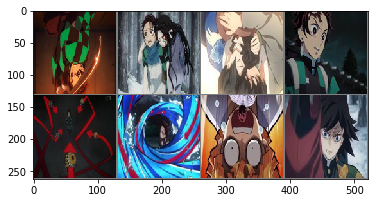

In [10]:
imshow(make_grid(image_B, nrow=4))

In [0]:
# model定義
class ResNet(nn.Module):
    def __init__(self, input_dim):
        super(ResNet, self).__init__()
        conv_block = [nn.ReflectionPad2d(1),
                      nn.Conv2d(input_dim, input_dim, kernel_size=3),
                      nn.InstanceNorm2d(input_dim),
                      nn.ReLU(True),
                      nn.ReflectionPad2d(1),
                      nn.Conv2d(input_dim, input_dim, kernel_size=3),
                      nn.InstanceNorm2d(input_dim),
                      ]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        output = x + self.conv_block(x)
        return output

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ReflectionPad2d(input_dim),
            nn.Conv2d(input_dim, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(True),

            ResNet(256),
            ResNet(256),
            ResNet(256),
            ResNet(256),
            ResNet(256),
            ResNet(256),
            ResNet(256),
            ResNet(256),
            ResNet(256),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_dim, kernel_size=7, stride=1, padding=0),
            nn.Tanh()
        )

        self.model.apply(self.init_weights)

    def forward(self, x):
        return self.model(x)

    def init_weights(self, m):
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            nn.init.normal(m.weight.data, 0.0, 0.02)

class Discriminator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(input_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(512, output_dim, kernel_size=4, stride=1, padding=1)
        )

        self.model.apply(self.init_weights)

    def forward(self, x):
        return self.model(x)

    def init_weights(self, m):
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            nn.init.normal(m.weight.data, 0.0, 0.01)

In [12]:
def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

gen = Generator(1,3)
print_network(gen)

disc = Discriminator(1,3)
print_network(disc)

Generator(
  (model): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNet(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Con

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [13]:
from torchsummary import summary
gen = gen.cuda()
disc = disc.cuda()
summary(gen, input_size=(1, 256,256))
summary(disc, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 1, 258, 258]               0
            Conv2d-2         [-1, 64, 252, 252]           3,200
    InstanceNorm2d-3         [-1, 64, 252, 252]               0
              ReLU-4         [-1, 64, 252, 252]               0
            Conv2d-5        [-1, 128, 126, 126]          73,856
    InstanceNorm2d-6        [-1, 128, 126, 126]               0
              ReLU-7        [-1, 128, 126, 126]               0
            Conv2d-8          [-1, 256, 63, 63]         295,168
    InstanceNorm2d-9          [-1, 256, 63, 63]               0
             ReLU-10          [-1, 256, 63, 63]               0
  ReflectionPad2d-11          [-1, 256, 65, 65]               0
           Conv2d-12          [-1, 256, 63, 63]         590,080
   InstanceNorm2d-13          [-1, 256, 63, 63]               0
             ReLU-14          [-1, 256,

In [0]:
# loss定義
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return Variable(images)
        return_images = []
        for image in images:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs += 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

class GANLoss(nn.Module):
    def __init__(self):
        super(GANLoss, self).__init__()
        self.real_label_var = None
        self.fake_label_var = None
        self.mseloss = nn.MSELoss()

    def get_target_tensor(self, input, target_is_real):
        target_tensor = None
        if target_is_real:
            create_label = (self.real_label_var is None) or (self.real_label_var.numel() != input.numel())
            if create_label:
                real_tensor = torch.ones(input.size())
                if cuda:
                    real_tensor = real_tensor.cuda()
                self.real_label_var = Variable(real_tensor, requires_grad=False)
            target_tensor = self.real_label_var
        else:
            create_label = (self.fake_label_var is None) or (self.fake_label_var.numel() != input.numel())
            if create_label:
                fake_tensor =torch.zeros(input.size())
                if cuda:
                    fake_tensor = fake_tensor.cuda()
                self.fake_label_var = Variable(fake_tensor, requires_grad=False)
            target_tensor = self.fake_label_var
        return target_tensor

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.mseloss(input, target_tensor)

In [0]:
class CycleGAN():
    def __init__(self, log_dir="logs"):
        self.netG_A = Generator(3,3)
        self.netG_B = Generator(3,3)
        self.netD_A = Discriminator(3,3)
        self.netD_B = Discriminator(3,3)

        if cuda:
            self.netG_A.cuda()
            self.netG_B.cuda()
            self.netD_A.cuda()
            self.netD_B.cuda()

        self.fake_A_pool = ImagePool(50)
        self.fake_B_pool = ImagePool(50)

        self.criterionGAN = GANLoss()
        self.criterionCycle = torch.nn.L1Loss()
        self.criterionIdt = torch.nn.L1Loss()

        self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()),
                                            lr=lr,
                                            betas=(beta1,0.999))

        self.optimizer_D_A = torch.optim.Adam(self.netD_A.parameters(),
                                              lr=lr,
                                              betas=(beta1, 0.999))
        
        self.optimizer_D_B = torch.optim.Adam(self.netD_B.parameters(),
                                              lr=lr,
                                              betas=(beta1, 0.999))
        
        self.optimizers = []
        self.optimizers.append(self.optimizer_G)
        self.optimizers.append(self.optimizer_D_A)
        self.optimizers.append(self.optimizer_D_B)

        self.log_dir = Path(log_dir)
        if not self.log_dir.exists():
            os.makedirs(log_dir)

        self.loss_all = None


    def set_up(self, input):
        input_A = input["A"]
        input_B = input["B"]
        
        if cuda:
            input_A = input_A.cuda()
            input_B = input_B.cuda()

        self.input_A = input_A
        self.input_B = input_B
        self.images_path = None

    def backward_G(self, real_A, real_B):
        lambda_idt = 0.5
        lambda_A = 10.0
        lambda_B = 10.0

        # B=>AtoB(B)
        idt_B = self.netG_A(real_B)
        loss_idt_A = lambda_idt*lambda_B * self.criterionIdt(idt_B, real_B)

        # A=>BtoA(A)
        idt_A = self.netG_B(real_A)
        loss_idt_B = lambda_idt*lambda_A * self.criterionIdt(idt_A, real_A)

        # A=>B
        fake_B = self.netG_A(real_A)
        pred_fake_A = self.netD_A(fake_B)
        loss_G_B = self.criterionGAN(pred_fake_A, True)

        fake_A = self.netG_B(real_B)
        pred_fake_B = self.netD_B(fake_A)
        loss_G_A = self.criterionGAN(pred_fake_B, True)

        # A=>B=>A
        rec_A = self.netG_B(fake_B)
        loss_cycle_A = lambda_A * self.criterionCycle(rec_A, real_A)

        # B=>A=>B
        rec_B = self.netG_A(fake_A)
        loss_cycle_B = lambda_B * self.criterionCycle(rec_B, real_B)

        #lossのさめんしょん
        loss = loss_idt_A + loss_idt_B + loss_G_B + loss_G_A + loss_cycle_A + loss_cycle_B
        loss.backward()

        return loss_idt_A.detach(), loss_idt_B.detach(), loss_G_A.detach(), loss_G_B.detach(), \
            loss_cycle_A.detach(), loss_cycle_B.detach(), fake_A.data, fake_B.data

    def backward_D_A(self, real_B, fake_B):
        fake_B = self.fake_B_pool.query(fake_B)

        # netD_AはBかどうか判別
        pred_real = self.netD_A(real_B)
        loss_D_real = self.criterionGAN(pred_real, True)

        pred_fake = self.netD_A(fake_B.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)

        loss = 1./2.*(loss_D_real+loss_D_fake)
        loss.backward()

        return loss.detach()

    def backward_D_B(self, real_A, fake_A):
        fake_A = self.fake_A_pool.query(fake_A)
        fake_A = fake_A.detach()

        pred_real = self.netD_B(real_A)
        loss_D_real = self.criterionGAN(pred_real, True)

        pred_fake = self.netD_B(fake_A)
        loss_D_fake = self.criterionGAN(pred_fake, False)

        loss = 1./2.*(loss_D_real + loss_D_fake)
        loss.backward()

        return loss.detach()

    def optimize(self):
        real_A = Variable(self.input_A)
        real_B = Variable(self.input_B)

        self.optimizer_G.zero_grad()
        loss_idt_A, loss_idt_B, loss_G_A, loss_G_B, loss_cycle_A, loss_cycle_B, fake_A, fake_B =\
            self.backward_G(real_A, real_B)
        self.optimizer_G.step()
        self.optimizer_D_A.zero_grad()
        loss_D_A = self.backward_D_A(real_B, fake_B)
        self.optimizer_D_A.step()

        self.optimizer_D_B.zero_grad()
        loss_D_B = self.backward_D_B(real_A, fake_A)
        self.optimizer_D_B.step()

        loss_all = [loss_G_A, loss_D_A,
                    loss_G_B, loss_D_B,
                    loss_idt_A, loss_idt_B,
                    loss_cycle_A, loss_cycle_B]
        
        loss_all = np.array(loss_all, dtype=float)

        return loss_all

    def train(self, data_loader):
        losses = np.zeros(8, dtype=float)
        for batch_idx, data in enumerate(data_loader):
            self.set_up(data)
            losses_i = self.optimize()
            losses += losses_i

        self.loss_all = losses

        return losses/len(data_loader)

    def save(self, epoch, loss_only):
        save_file = "{}epoch.pth".format(epoch+1)
        save_path = self.log_dir / save_file
        if loss_only:
            torch.save({
                "epoch":epoch,
                "loss_all":self.loss_all
            },save_path)
            print("loss only can be saved at {}".format(save_path))
        else:
            torch.save({
                "epoch":epoch,
                "netG_A_state_dict":self.netG_A.cpu().state_dict(),
                "netD_A_state_dict":self.netD_A.cpu().state_dict(),
                "netG_B_state_dict":self.netG_B.cpu().state_dict(),
                "netD_B_state_dict":self.netD_B.cpu().state_dict(),
                "loss_all":self.loss_all
            },save_path)
            print("checkpoint can be saved at {}".format(save_path))
        # GPUに戻す
        if torch.cuda.is_available():
            self.netG_A.cuda()
            self.netD_A.cuda()
            self.netG_B.cuda()
            self.netD_B.cuda()

    def load(self, epoch):
        load_file = "{}epoch.pth".format(epoch+1)
        load_path = self.log_dir / load_file
        checkpoint = torch.load(load_path)
        # load
        self.netG_A.load_state_dict(checkpoint["netG_A_state_dict"])
        self.netD_A.load_state_dict(checkpoint["netD_A_state_dict"])
        self.netG_B.load_state_dict(checkpoint["netG_B_state_dict"])
        self.netD_B.load_state_dict(checkpoint["netD_B_state_dict"])
        print("{} epoch model load can be done".format(epoch+1))
        # GPUに戻す
        if torch.cuda.is_available():
            self.netG_A.cuda()
            self.netD_A.cuda()
            self.netG_B.cuda()
            self.netD_B.cuda()

    def plot_sample(self,idx, data_loader):
        inputs = iter(data_loader).next()
        A = inputs["A"]
        with torch.no_grad():
            gen_B = self.netG_A.cpu()(A)
            imshow(make_grid(gen_B))
        self.netG_A.cuda()
        return None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


291 epoch model load can be done
Epoch 291, Losses: [0.498372   0.33851359 0.53917074 0.26891454 0.66517486 0.41453629
 1.10391316 1.42510316], Time 142.3447961807251
checkpoint can be saved at /content/drive/My Drive/sentan2/logs/291epoch.pth
Epoch 292, Losses: [0.47617437 0.27785414 0.48933113 0.24438674 0.6331331  0.39995007
 1.08915647 1.37890354], Time 42.73078393936157
loss only can be saved at /content/drive/My Drive/sentan2/logs/292epoch.pth
Epoch 293, Losses: [0.50833413 0.23150993 0.46346917 0.22918316 0.66724915 0.42063028
 1.16574986 1.43828702], Time 26.92825961112976
loss only can be saved at /content/drive/My Drive/sentan2/logs/293epoch.pth
Epoch 294, Losses: [0.47021944 0.32302332 0.55926847 0.26271795 0.62559611 0.4032573
 1.07688444 1.36142519], Time 25.72251558303833
loss only can be saved at /content/drive/My Drive/sentan2/logs/294epoch.pth
Epoch 295, Losses: [0.49918705 0.21250882 0.44448401 0.21939027 0.63802785 0.41075112
 1.10731698 1.40584414], Time 22.31819248

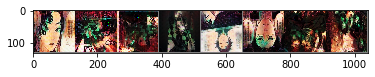

In [0]:
model = CycleGAN(LOG_DIR)
#writer = SummaryWriter(LOG_DIR)

SAVE_EPOCH_FREQ = 5
PLOT_FREQ = 1

## LOAD
LOAD_FLAG = True
START_EPOCH =290
start_time = time.time()

if LOAD_FLAG:
    assert START_EPOCH != 0, "start epochは１以上"
    model.load(epoch=START_EPOCH)
else:
    assert START_EPOCH==0, "start epochは0"
    pass

for epoch in range(START_EPOCH, NUM_EPOCH):
    losses = model.train(train_loader)
    elapsed = time.time() - start_time
    print('Epoch %d, Losses: %s, Time %s' % (epoch + 1, losses, elapsed))

    if epoch % SAVE_EPOCH_FREQ == 0:
        model.save(epoch, loss_only=False)
    else:
        model.save(epoch, loss_only=True)

    if epoch % PLOT_FREQ == 0:
        model.plot_sample(0,train_loader)

    start_time = time.time()

In [0]:
def plot_losses(num_epoch):
    loss_G_A, loss_D_A, loss_G_B, loss_D_B, loss_cycle_A, loss_cycle_B, loss_idt_A, loss_idt_B =\
        [], [], [], [], [], [], [], []
    for epoch in range(1,num_epoch+1):
        load_file = "{}epoch.pth".format(epoch)
        load_path = Path(LOG_DIR) / load_file
        checkpoint = torch.load(load_path)
        loss_all = checkpoint["loss_all"]
        loss_G_A.append(loss_all[0])
        loss_D_A.append(loss_all[1])
        loss_G_B.append(loss_all[2])
        loss_D_B.append(loss_all[3])
        loss_cycle_A.append(loss_all[4])
        loss_cycle_B.append(loss_all[5])
        loss_idt_A.append(loss_all[6])
        loss_idt_B.append(loss_all[7])
    
    plt.plot(range(1,num_epoch+1), loss_G_A, label="Gen A to B")
    plt.plot(range(1,num_epoch+1), loss_D_A, label="Disc A to B")
    plt.plot(range(1,num_epoch+1), loss_G_B, label="Gen B to A")
    plt.plot(range(1,num_epoch+1), loss_D_B, label="Disc B to A")
    plt.plot(range(1,num_epoch+1), loss_cycle_A, label="Cycle A")
    plt.plot(range(1,num_epoch+1), loss_cycle_B, label="Cycle B")
    plt.plot(range(1,num_epoch+1), loss_idt_A, label="Idt A")
    plt.plot(range(1,num_epoch+1), loss_idt_B, label="Idt B")
    plt.legend()
    plt.savefig(data_path+"/output/{}_loss.png".format(num_epoch))
    plt.show()

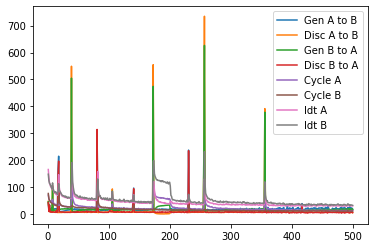

In [23]:
plot_losses(500)

In [24]:
model1 = CycleGAN(LOG_DIR)
model1.load(epoch=500)
model2 = CycleGAN(LOG_DIR)
model2.load(epoch=300)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


501 epoch model load can be done
301 epoch model load can be done


In [25]:
test_dataset = DataLoader(is_train=False)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=0)

root is /content/drive/My Drive/sentan2/data/manga2anime
A size : 8
B size : 1


In [0]:
num_out = 15
before_img = []
after1_img = []
after2_img = []
with torch.no_grad():
    for i in range(num_out):
        batch = iter(test_loader).next()
        before_img.append(batch["A"][0])
        after1_img.append(model1.netG_A.cpu()(batch['A'])[0])
        after2_img.append(model2.netG_A.cpu()(batch["A"])[0])

In [26]:
before_img

[tensor([[[[ 0.1686, -0.0588, -0.0118,  ...,  0.9843,  0.9765,  0.9922],
           [ 0.2314,  0.0667,  0.0980,  ...,  1.0000,  1.0000,  0.9922],
           [ 0.9765,  0.7961,  0.4039,  ...,  1.0000,  1.0000,  0.9922],
           ...,
           [ 0.7176, -0.4353,  0.0196,  ...,  0.9216,  0.9922,  0.9922],
           [-0.1137, -0.1294,  0.8353,  ...,  1.0000,  0.9843,  0.9922],
           [-0.0510,  0.5451,  0.9765,  ...,  1.0000,  0.9843,  0.9922]],
 
          [[ 0.1686, -0.0588, -0.0118,  ...,  0.9843,  0.9765,  0.9922],
           [ 0.2314,  0.0667,  0.0980,  ...,  1.0000,  1.0000,  0.9922],
           [ 0.9765,  0.7961,  0.4039,  ...,  1.0000,  1.0000,  0.9922],
           ...,
           [ 0.7176, -0.4353,  0.0196,  ...,  0.9216,  0.9922,  0.9922],
           [-0.1137, -0.1294,  0.8353,  ...,  1.0000,  0.9843,  0.9922],
           [-0.0510,  0.5451,  0.9765,  ...,  1.0000,  0.9843,  0.9922]],
 
          [[ 0.1686, -0.0588, -0.0118,  ...,  0.9843,  0.9765,  0.9922],
           [ 

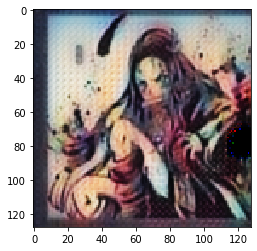

In [27]:
for i in range(num_out):
    imshow(before_img[i], save=True, fname=data_path+"/output/{}_before.png".format(i))
    imshow(after1_img[i], save=True, fname=data_path+"/output/{}_after1.png".format(i))
    imshow(after2_img[i], save=True, fname=data_path+"/output/{}_after2.png".format(i))

In [0]:
batch = iter(test_loader).next()
print(batch['A'].shape)
print(batch['B'].shape)
print(batch['path_A'])
print(batch['path_B'])

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
['/content/drive/My Drive/sentan2/data/manga2anime/testdata_A/518.jpg']
['/content/drive/My Drive/sentan2/data/manga2anime/testdata_B/015.jpg']


(-0.5, 127.5, 127.5, -0.5)

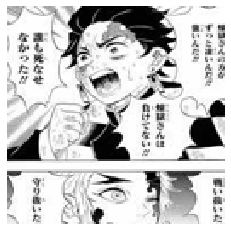

In [0]:
imshow(make_grid(batch['A']))
plt.axis('off')

In [0]:
model = CycleGAN(LOG_DIR)
epoch = 500
model.load(epoch)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


501 epoch model load can be done


In [0]:
model.netG_A.eval()

Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNet(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Con

In [0]:
# 馬をシマウマに変換
with torch.no_grad():
    fake_B = model.netG_A.cpu()(batch['A'])
    print(fake_B.shape)

torch.Size([1, 3, 128, 128])


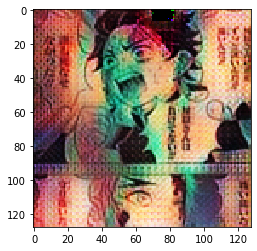

In [0]:
imshow(fake_B[0])

In [0]:
batch = iter(test_loader).next()
fake_A = model.netG_B.cpu()(batch['B'])
print(fake_A.shape)

torch.Size([1, 3, 128, 128])


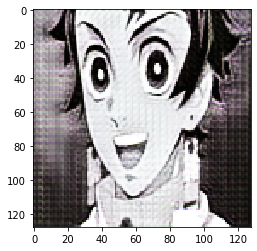

In [0]:
imshow(fake_A.detach()[0])